In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image

from sklearn.preprocessing import MinMaxScaler

from PIL import Image

import os
from datetime import datetime

In [2]:
## creating function to rescale data from -1 to 1 to 0 to 1
def img_rescale(img):
    return (img + 1) * 0.5

In [3]:
## creating folder for saving images
if not os.path.exists("gan_images"):
    os.makedirs("gan_images")

In [4]:
## creating the transformers
resize_shape = (50, 50)
transform = transforms.Compose([
    transforms.Resize(resize_shape),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

In [9]:
## getting images dataset
root = "x__data"
dataset = ImageFolder(root, transform=transform)

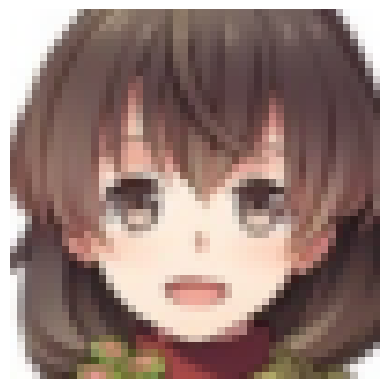

In [10]:
idx = np.random.randint(len(dataset))
plt.imshow(img_rescale(dataset[idx][0].permute(1,2,0)))
plt.axis(False)
plt.show()

In [11]:
## creating models
input_size = resize_shape[0] * resize_shape[1] * 3
latent_size = 150

## creating the discriminator
discriminator = nn.Sequential(
    nn.Linear(input_size, 1024),
    nn.LeakyReLU(0.2),
    nn.Linear(1024, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1)
)

## creating generator
generator = nn.Sequential(
    nn.Linear(latent_size, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, input_size),
    nn.Tanh()
)

In [77]:
## getting the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [78]:
## moving to device
discriminator.to(device)
generator.to(device)

Sequential(
  (0): Linear(in_features=150, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
  (3): Linear(in_features=256, out_features=512, bias=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
  (6): Linear(in_features=512, out_features=1024, bias=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): BatchNorm1d(1024, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
  (9): Linear(in_features=1024, out_features=7500, bias=True)
  (10): Tanh()
)

In [79]:
## creating loss and optimizer
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5,0.999))

In [80]:
## creating the dataloaders
batch_size = 128
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [81]:
## creating the training function
def batch_gd(data_loader, criterion, discriminator=None, generator=None, d_optimizer=None, g_optimizer=None, epochs=100):
    assert discriminator and generator and d_optimizer and g_optimizer,\
    "`discriminator`, `generator`, `d_optimizer` and `g_optmizer` must be declared"

    ones = torch.ones(batch_size, 1).to(device)
    zeros = torch.zeros(batch_size, 1).to(device)

    d_losses = []
    g_losses = []
    
    for it in range(epochs):
        t0 = datetime.now()
        for inputs, _ in data_loader:
            n = inputs.size(0)
            inputs = inputs.view(n, -1).to(device)
            ############################
            ## training discriminator ##
            ############################

            ## passing real images through discriminator
            batch_ones = ones[:n]
            d_real_outputs = discriminator(inputs)
            d_real_loss = criterion(d_real_outputs, batch_ones)

            ## passing fake images through discriminator
            batch_zeros = zeros[:n]
            noise = torch.randn(n, latent_size).to(device)
            gen_outputs = generator(noise)
            d_fake_outputs = discriminator(gen_outputs)
            d_fake_loss = criterion(d_fake_outputs, batch_zeros)

            d_loss = (d_real_loss + d_fake_loss) * 0.5
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            ########################
            ## training generator ##
            ########################
            for _ in range(2):
                noise = torch.randn(n, latent_size).to(device)
                gen_outputs = generator(noise)
                d_gen_outputs = discriminator(gen_outputs)
                g_loss = criterion(d_gen_outputs, batch_ones)

                d_optimizer.zero_grad()
                g_optimizer.zero_grad()

                g_loss.backward()
                g_optimizer.step()


        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        dt = datetime.now() - t0
        
        print(f"Epoch: {it+1}\{epochs} discriminator_loss: {d_loss.item()}, generator_loss: {g_loss.item()}, Duration: {dt}")

        ## saving images
        fake_images = gen_outputs.reshape(-1, 3, *resize_shape)
        save_image(img_rescale(fake_images), f"gan_images/{it+1}.png")
        
    return d_losses, g_losses

In [82]:
d_losses, g_losses = batch_gd(loader,
                              criterion,
                              discriminator=discriminator,
                              generator=generator,
                              d_optimizer=d_optimizer,
                              g_optimizer=g_optimizer,
                              epochs=200
                             )

Epoch: 1\200 discriminator_loss: 0.6727403402328491, generator_loss: 0.7076877951622009, Duration: 0:00:44.545224
Epoch: 2\200 discriminator_loss: 0.7110308408737183, generator_loss: 0.8094875812530518, Duration: 0:00:42.243873
Epoch: 3\200 discriminator_loss: 0.6855466365814209, generator_loss: 0.7541376352310181, Duration: 0:00:42.204384
Epoch: 4\200 discriminator_loss: 0.6965597867965698, generator_loss: 0.7442161440849304, Duration: 0:00:43.253680
Epoch: 5\200 discriminator_loss: 0.6922527551651001, generator_loss: 0.7149099111557007, Duration: 0:00:43.093458
Epoch: 6\200 discriminator_loss: 0.6904270648956299, generator_loss: 0.7195167541503906, Duration: 0:00:43.019003
Epoch: 7\200 discriminator_loss: 0.6907920241355896, generator_loss: 0.7079349756240845, Duration: 0:00:43.087460
Epoch: 8\200 discriminator_loss: 0.6926199197769165, generator_loss: 0.6919642090797424, Duration: 0:00:42.528714
Epoch: 9\200 discriminator_loss: 0.6924518346786499, generator_loss: 0.6930906772613525,

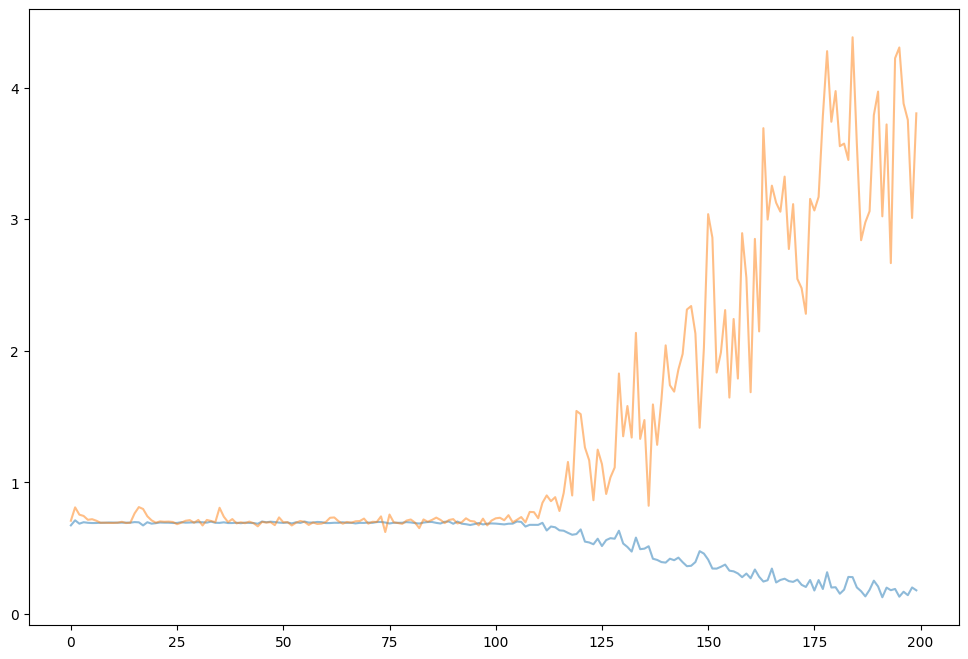

In [93]:
## PLOTTING
fig = plt.figure(figsize=(12,8))
plt.plot(d_losses, alpha=0.5)
plt.plot(g_losses, alpha=0.5)
plt.show()

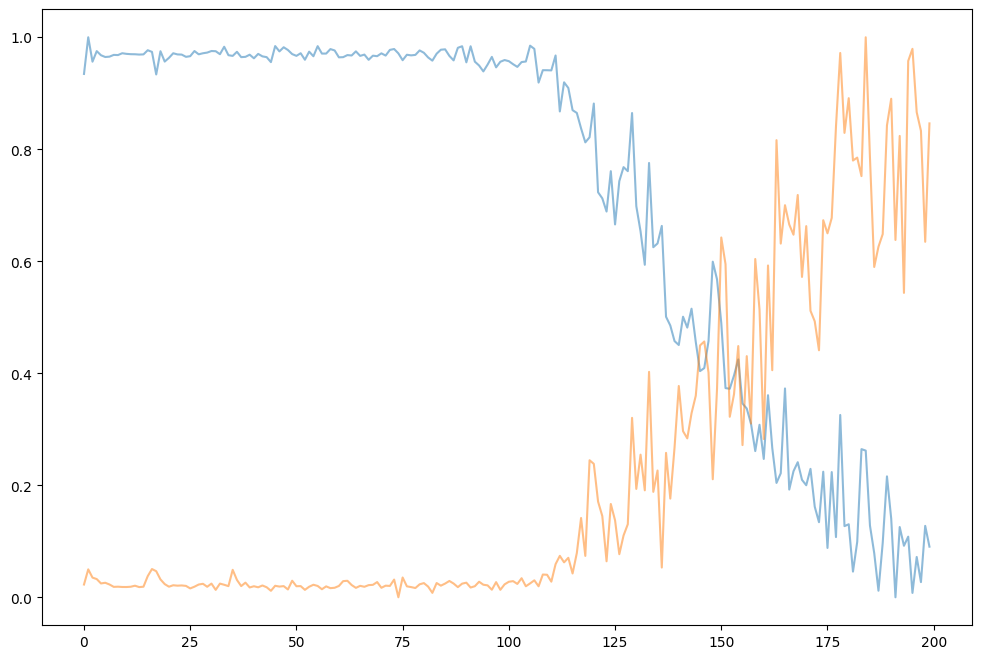

In [94]:
## PLOTTING WITH LOSSES SCALED
scaler = MinMaxScaler()
d_losses_scaled = scaler.fit_transform(np.array(d_losses).reshape(-1,1))
g_losses_scaled = scaler.fit_transform(np.array(g_losses).reshape(-1,1))
fig = plt.figure(figsize=(12,8))
plt.plot(d_losses_scaled, alpha=0.5)
plt.plot(g_losses_scaled, alpha=0.5)
plt.show()

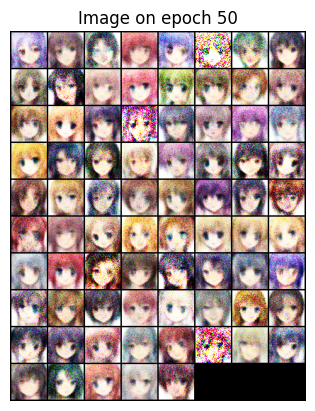

In [85]:
## image on epoch 50
img_ind = 50
img = Image.open(f"gan_images/{img_ind}.png")
plt.title(f"Image on epoch {img_ind}")
plt.axis("off")
plt.imshow(img)

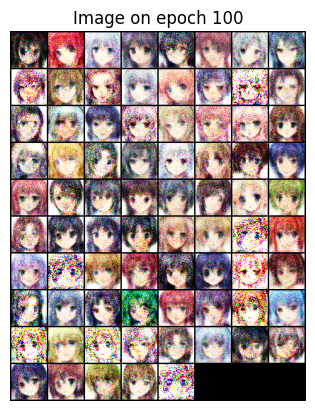

In [86]:
## image on epoch 50
img_ind = 100
img = Image.open(f"gan_images/{img_ind}.png")
plt.title(f"Image on epoch {img_ind}")
plt.axis("off")
plt.imshow(img)

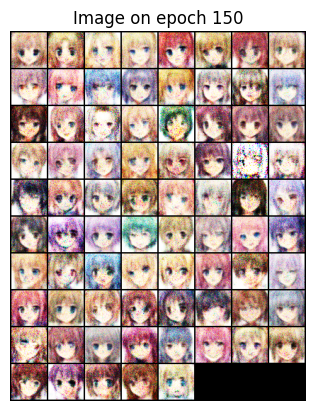

In [87]:
## image on epoch 50
img_ind = 150
img = Image.open(f"gan_images/{img_ind}.png")
plt.title(f"Image on epoch {img_ind}")
plt.axis("off")
plt.imshow(img)

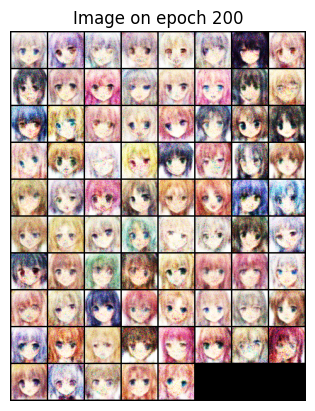

In [88]:
## image on epoch 50
img_ind = 200
img = Image.open(f"gan_images/{img_ind}.png")
plt.title(f"Image on epoch {img_ind}")
plt.axis("off")
plt.imshow(img)

In [92]:
## saving generators and discriminators
## saving generators
# if not os.path.exists("models"):
#     os.mkdir("models")

# torch.save(generator.state_dict(), "models/anime_face_generator.tm")
# torch.save(discriminator.state_dict(), "models/anime_face_discriminator.tm")